In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.api.types import CategoricalDtype
import seaborn as sns
import statsmodels.api as sm
from plotnine import *
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report 
from sklearn.metrics import roc_auc_score, roc_curve
import xgboost as xgb
from xgboost import XGBClassifier

## Introduction

An Insurance company that has provided Health Insurance to its customers wishes to build a
model to predict whether the policyholders (customers) from the past year will also be
interested in Vehicle Insurance provided by the company.

Building a model to predict whether a customer would be interested in Vehicle Insurance is
extremely helpful for the company because it can then accordingly plan its communication
strategy to reach out to those customers and optimize its business model and revenue.

## Dataset Description

| Variable         | Definition   |
| ------------------| ------------ |
| id         |  Unique ID for the customer    |
| Gender        |  Gender of the customer    |
| Age         |  Age of the customer    |
| Driving_License        |  0 : Customer does not have DL, 1 : Customer already has DL    |
| Region_Code        |  Unique code for the region of the customer    |
| Previously_Insured         |  1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance   |
| Vehicle_Age        |  Age of the Vehicle, including 3 groups: < 1 Year, > 2 Years, 1-2 Year    |
| Vehicle_Damage         |  1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.    |
| Annual_Premium        |  The amount customer needs to pay as premium in the year    |
| Policy_Sales_Channel        |  Anonymized Code for the channel of outreaching to the customer ie. Diﬀerent Agents, Over Mail, Over Phone, In Person, etc.    |
| Vintage         |  Number of Days, Customer has been associated with the company    |
| Response        |  1 : Customer is interested, 0 : Customer is not interested    |



We drop the id variable as it is a unique identifier for each observation and not a feature to be used

In [2]:
df = pd.read_csv('train.csv')
# df.drop(['id', 'Region_Code', 'Policy_Sales_Channel'], axis = 1, inplace = True)
df.drop(['id'], axis = 1, inplace = True)
df1 = df
df

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0
...,...,...,...,...,...,...,...,...,...,...,...
381104,Male,74,1,26.0,1,1-2 Year,No,30170.0,26.0,88,0
381105,Male,30,1,37.0,1,< 1 Year,No,40016.0,152.0,131,0
381106,Male,21,1,30.0,1,< 1 Year,No,35118.0,160.0,161,0
381107,Female,68,1,14.0,0,> 2 Years,Yes,44617.0,124.0,74,0


## Exploratory Data Analysis

Ensuring that there are no null vlues in the data

In [3]:
df.isnull().values.any() # no null values

False

In [4]:
count_no = sum(df['Response']==0)
n = sum(df['Response'].value_counts())
print("number of observations:", n)
print("percentage of not interested", count_no/n*100)
print("percentage of interested", (1 - count_no/n)*100)

print("customer age ranges from ", df['Age'].min(), 'to', df['Age'].max())
print("propertion of male clients:", sum(df['Gender'] == 'Male')/n)
print("proportion of clients that already have vehicle insurance:", sum(df['Previously_Insured'])/n)
print("proportion of clients with a drivers license:", sum(df['Driving_License'])/n)



number of observations: 381109
percentage of not interested 87.74366388618479
percentage of interested 12.256336113815202
customer age ranges from  20 to 85
propertion of male clients: 0.5407613045086839
proportion of clients that already have vehicle insurance: 0.4582101183650871
proportion of clients with a drivers license: 0.9978693759528114


The data includes 381109 observations with no missing values. 88% of the customers are not
interested in the vehicle while others are interested. 46% of the customers are female while
others are male. The customers are aged from 20 to 85, and a median of 45.82% of the
customers have previously been insured while the others have not. Almost every customer has a
driving license.

As we can see, the data appears to be heavily unbalanced, we will look to deal with this problem.

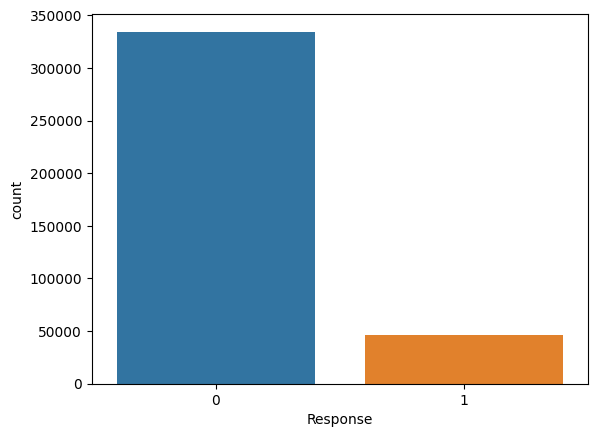

In [5]:
df['Response'].value_counts() # unbalanaced data
# Creating Bar Plot
sns.countplot(x = 'Response', data = df)
plt.show()

Here we investigate our categorical features and their frequencies

'Driving_License' will not be a useful predictor, since nearly all current policy holders have one. The other 3 categorical predictors are roughly split 50/50

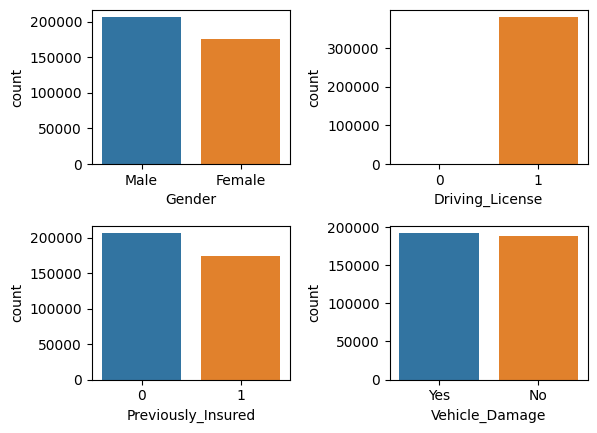

In [6]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.5)
fig.add_subplot(2, 2, 1)
sns.countplot(x = 'Gender', data = df)
fig.add_subplot(2, 2, 2)
sns.countplot(x = 'Driving_License', data = df)
fig.add_subplot(2, 2, 3)
sns.countplot(x = 'Previously_Insured', data = df)
fig.add_subplot(2, 2, 4)
sns.countplot(x = 'Vehicle_Damage', data = df)
plt.show()


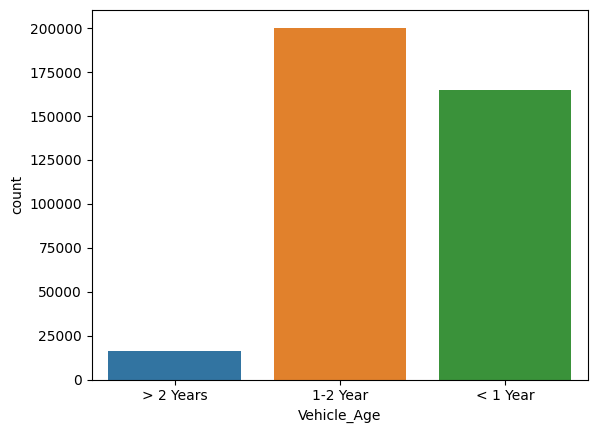

In [7]:
sns.countplot(x = 'Vehicle_Age', data = df)
plt.show()

# Investigating the relationship between the response and categorical predictors

The plot shows that if a customer has had their vehicle damaged before, they are more likely to get vehicle insurance.


<Axes: xlabel='Response'>

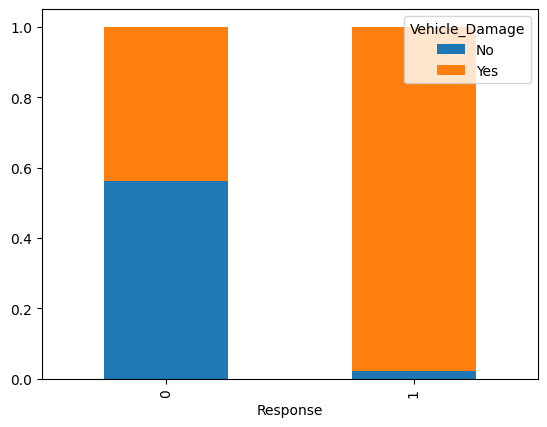

In [8]:
(pd.crosstab(df['Response'],df['Vehicle_Damage'], 
             normalize='index')
   .plot.bar(stacked=True)
)


There may be a relation with vehicle age. Those with cars less than 1 year old are less likely to want vehicle insurance

<Axes: xlabel='Vehicle_Age'>

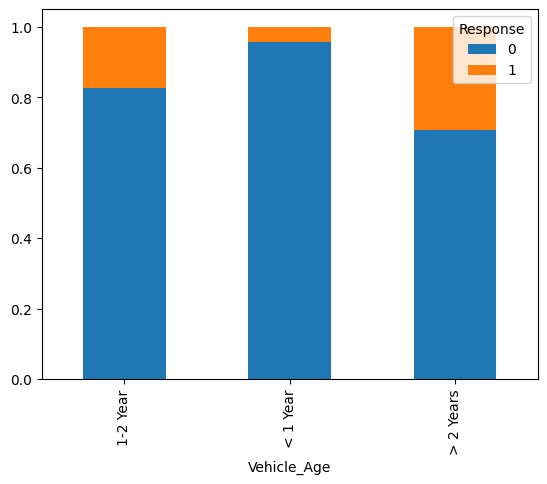

In [9]:
(pd.crosstab(df['Vehicle_Age'], df['Response'], 
             normalize='index')
   .plot.bar(stacked=True)
)


If a policyholder already has vehicle insurance, they most likely won't be interested in changing

<Axes: xlabel='Response'>

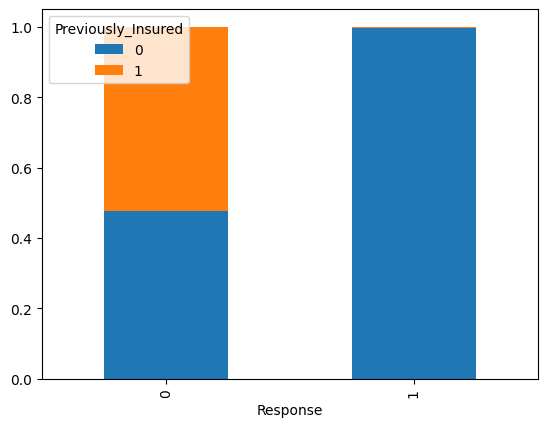

In [10]:
(pd.crosstab(df['Response'],df['Previously_Insured'], 
             normalize='index')
   .plot.bar(stacked=True)
)


male/female split isn't too far off 50%, but it seems that men might be more interested in adding vehicle insurance. Although the relation doesn't seem strong


<Axes: xlabel='Response'>

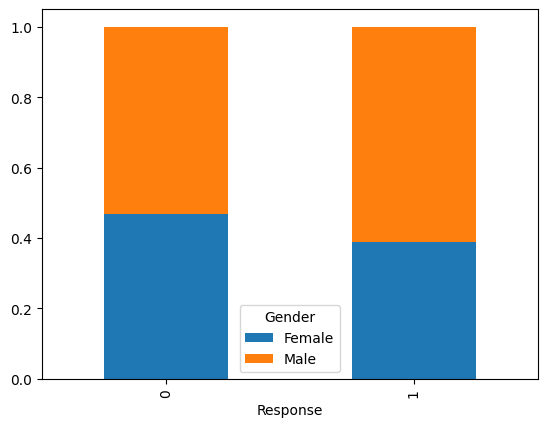

In [11]:
(pd.crosstab(df['Response'],df['Gender'], 
             normalize='index')
   .plot.bar(stacked=True)
)


Therefore we can expect Previously_Insured, Vehicle_Age and Vehicle_Damage to be useful categorical predictors in our model, while Gender might not be.

# Investigating the continuous variables and their distributions based on the response

We investigate how the distributions of each variable change depending on the value of the response. 
We first look at the age of the policy holder, we can see that for either value of the response, the densities look different. Indicating that policy holders who are younger (below ~35) are less likely to be interested, while policy holders between ~35 and 60 are more likely to be interested. This could be a useful predictor

(15.0, 85.0)

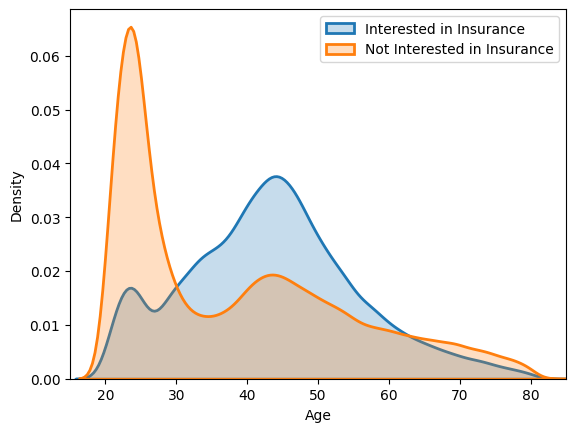

In [12]:
sns.kdeplot(df.loc[df['Response'] == 1, 'Age'], linewidth=2, fill=True, label = "Interested in Insurance")
sns.kdeplot(df.loc[df['Response'] == 0, 'Age'], linewidth=2, fill=True, label = "Not Interested in Insurance")
plt.legend(loc="upper right")
plt.xlim(15,85)

The plots for Annual_Premium for both values of the response look very similar, this may not be a useful variable

(0.0, 125000.0)

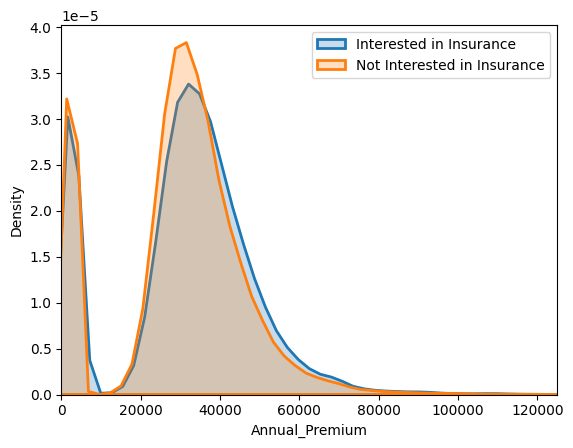

In [13]:
sns.kdeplot(df.loc[df['Response'] == 1, 'Annual_Premium'], linewidth=2, fill=True, label = "Interested in Insurance")
sns.kdeplot(df.loc[df['Response'] == 0, 'Annual_Premium'], linewidth=2, fill=True, label = "Not Interested in Insurance")
plt.legend(loc="upper right")
plt.xlim(0,125000)

These plots also look very similar, indicating that the number of days a customer has been associated with the company may not be important.

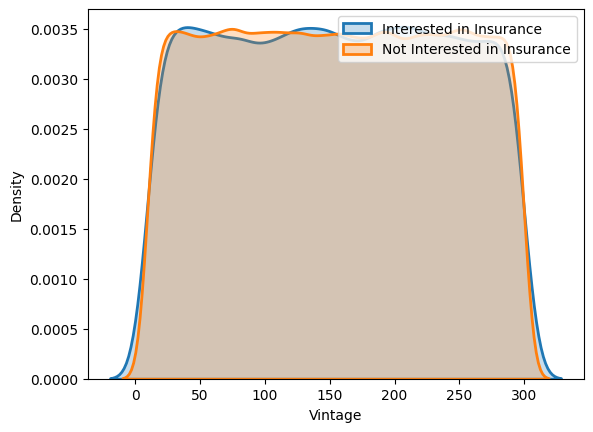

In [14]:
sns.kdeplot(df.loc[df['Response'] == 1, 'Vintage'], linewidth=2, fill=True, label = "Interested in Insurance")
sns.kdeplot(df.loc[df['Response'] == 0, 'Vintage'], linewidth=2, fill=True, label = "Not Interested in Insurance")
plt.legend(loc="upper right")

Of the numeric variables, we can see that Age and Previously_Insured may be good predictors of Response

## Data Processing

We convert categorical features to numeric values firstly and then into categorical variables

In [15]:
le = LabelEncoder() 
df['Gender'] = le.fit_transform(df['Gender']) 
df['Driving_License'] = le.fit_transform(df['Driving_License']) 
df['Previously_Insured'] = le.fit_transform(df['Previously_Insured']) 
df['Vehicle_Age'] = le.fit_transform(df['Vehicle_Age']) 
df['Vehicle_Damage'] = le.fit_transform(df['Vehicle_Damage']) 
df['Policy_Sales_Channel'] = le.fit_transform(df['Policy_Sales_Channel']) 
df['Region_Code'] = le.fit_transform(df['Region_Code'])
df['Response'] = le.fit_transform(df['Response'])

df['Gender'] = df['Gender'].astype('category')
df['Driving_License'] = df['Driving_License'].astype('category')
df['Previously_Insured'] = df['Previously_Insured'].astype('category')
df['Vehicle_Age'] = df['Vehicle_Age'].astype('category')
df['Vehicle_Damage'] = df['Vehicle_Damage'].astype('category')
df['Policy_Sales_Channel'] = df['Policy_Sales_Channel'].astype('category')
df['Region_Code'] = df['Region_Code'].astype('category')
df['Response'] = df['Response'].astype('category')

y = df['Response']
X = df.drop(['Response'], axis = 1)

df.dtypes

Gender                  category
Age                        int64
Driving_License         category
Region_Code             category
Previously_Insured      category
Vehicle_Age             category
Vehicle_Damage          category
Annual_Premium           float64
Policy_Sales_Channel    category
Vintage                    int64
Response                category
dtype: object

In [16]:
le = LabelEncoder() 
df1['Gender'] = le.fit_transform(df1['Gender']) 
df1['Driving_License'] = le.fit_transform(df1['Driving_License']) 
df1['Previously_Insured'] = le.fit_transform(df1['Previously_Insured']) 
df1['Vehicle_Age'] = le.fit_transform(df1['Vehicle_Age']) 
df1['Vehicle_Damage'] = le.fit_transform(df1['Vehicle_Damage']) 
df1['Region_Code'] = le.fit_transform(df1['Region_Code'])
df1['Policy_Sales_Channel'] = le.fit_transform(df1['Policy_Sales_Channel'])
df1['Response'] = le.fit_transform(df1['Response'])
y2 = df1['Response']
X2 = df1.drop(['Response'], axis = 1)

Although we have a training set, the response is not provided for this training set. In order to validate and deteremine model performance we will split the data into 3. Using two thirds as a testing set and the rest to test.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=32)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.33, random_state=32)

# Methods

Classiﬁcation methods require supervised machine learning algorithms to assign a
class/label to a set of data points. Some common algorithms include logistic regression, LDA,
QDA, and classiﬁcation trees. In this project, the goal is to classify a policyholder into one of
two classes while the models will use various factors to predict if an individual may be
interested in vehicle insurance.

### Confusion Matrix and Classiﬁcation Statistics:

In binary classiﬁcation problems, confusion matrices are used as important indicators of
model performance. These matrices compare the actual classiﬁcations with the predicted
classiﬁcations and display the counts of correctly and incorrectly classiﬁed observations. The
values on the diagonal represent the counts of correctly classiﬁed values, while the
remaining values represent the counts of incorrectly classiﬁed observations.
Additionally, some common statistics that are calculated from these values are used to assess
model performance, which include:
⦁ Accuracy: The proportion of observations that were classiﬁed correctly

⦁ Speciﬁcity: The proportion of negatives that are correctly classiﬁed

⦁ Sensitivity (Recall): The proportion of positives that are correctly classiﬁed

⦁ Precision: The proportion of predicted positives that were correctly classiﬁed

⦁ F1 Score: The harmonic mean between recall and precision


### Logistic Regression:

Logistic regression models, similarly to linear regression models, use a linear combination of
the predictors to predict the response. However, instead of estimating the response directly,
logistic regression uses the logit link function that links the linear combination of predictors
to the estimated probability of having a ʻpositiveʼ response.

### Decision Trees:

A non-parametric supervised machine learning algorithm, which can be used in both
regression and classiﬁcation problems. The general structure of a decision tree is as follows;
the root node is the top of the decision tree, as we descend down the tree, each node where a
decision must be made (and the predictor space is split) is called an internal node. At the
ends of the tree we have the terminal nodes that correspond to a subset of the predictor
space, and these provide the predicted value, or label the ones that are to be assigned to
predictors that are in those respective subsets. Decision trees result in highly interpretable
models that are very simple to explain.

### Boosting:

Boosting of decision trees is used to improve predictive capabilities by growing multiple trees
sequentially. Instead of training one large decision tree (strong classiﬁer) and risking
overﬁtting, the algorithm begins with much smaller trees (weak classiﬁers) that are ﬁtted and
incorporated in training subsequent trees so that each tree essentially learns from the
information provided by the tree(s) that were ﬁtted before it. In essence, the boosted model
will learn ʻslowlyʼ as more trees are ﬁt. Gradient boosting is a type of boosting technique
where each tree is speciﬁcally evaluated based on its loss function (which can be chosen by
the user), by using gradient descent optimization.

We will use XGBoost which is an implementation of gradient boosting. XGBoost finds better approximations by the use of second order gradients and advanced regularization. Training of XGBoost is faster as well.

### SMOTE:

When a dataset is unbalanced, like in our case, that nearly 90% of the responses are 0
(customers not interested in the new vehicle insurance). The predictions of models are likely
to be aﬀected by the majority class too much. Resampling
is a useful method to ﬁx this problem. We can oversample class 1 or undersample class 0 to
obtain a balanced dataset and use this new dataset to train our model.
SMOTE is a method that over-samples the minority (abnormal) class. SMOTE can achieve better classiﬁer performance.

# Machine Learning

As we can see in the confusion matrix below, the model over predicts 0 for the response. It will almost always conclude that the policy holder will not be interested. This is most likely due to the unbalanced data. Although the accuracy is 87.6% this doesn't mean too much to us as there are a large amounts of false negatives. The true positive rate is 0.01%, this classifier cannot really correctly predict many positive results (policy holders that would be interested in vehicle insurance), the F-score is 0.02 which is also very low. The result of amost always predicting response = 0 is an AUC of 0.5 as well.

In [18]:
logistic_model = LogisticRegression(max_iter = 1000).fit(X_train,y_train)

Accuracy :  0.876
Sensitivity :  0.01247
Specificity :  0.99592
Precision :  0.299
F1 Score:  0.024
AUC :  0.504
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    110372
           1       0.30      0.01      0.02     15394

    accuracy                           0.88    125766
   macro avg       0.59      0.50      0.48    125766
weighted avg       0.81      0.88      0.82    125766



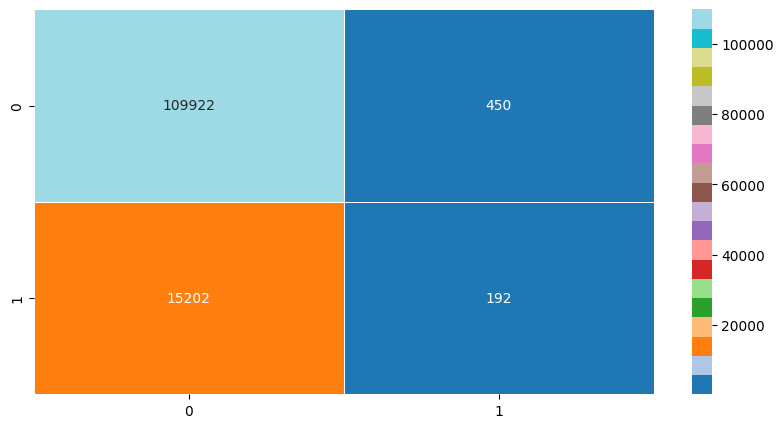

In [19]:
y_pred = logistic_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))
print("AUC : ", round(roc_auc_score(y_test, logistic_model.predict(X_test)), 3))

print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

Clearly our unbalanced data set is a problem, so we look to work around this problem via oversampling, SMOTE will oversample the lesser of the balanced data.

The SMOTE method producing NaN values when using the pandas dataframe so we convert to a numpy array for this step.

In [20]:
X_arr = np.array(X)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_arr, y, test_size = 0.2, random_state = 2)

os = SMOTE(random_state=0)

os_data_X, os_data_y = os.fit_resample(X_train1, y_train1)
os_data_X = pd.DataFrame(data = os_data_X, columns = X_train.columns)

os_data_X2, os_data_y2 = os.fit_resample(X_train2, y_train2)
os_data_X2 = pd.DataFrame(data = os_data_X2, columns = X_train2.columns)

In [21]:
logistic_model_os = LogisticRegression(max_iter=1000).fit(os_data_X, os_data_y)
y_pred_os = logistic_model_os.predict(X_test)

Accuracy :  0.634
Sensitivity :  0.50169
Specificity :  0.65231
Precision :  0.168
F1 Score:  0.251
AUC :  0.577
              precision    recall  f1-score   support

           0       0.90      0.65      0.76    110372
           1       0.17      0.50      0.25     15394

    accuracy                           0.63    125766
   macro avg       0.54      0.58      0.50    125766
weighted avg       0.81      0.63      0.70    125766



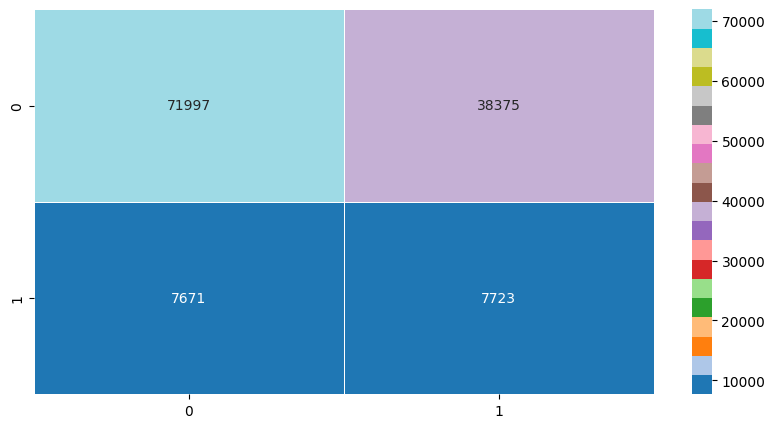

In [22]:
y_pred = logistic_model_os.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))
print("AUC : ", round(roc_auc_score(y_test, logistic_model_os.predict(X_test)), 3))
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

Although the SMOTE model appears to predict response = 1 more, it has a large false positive count, low accuracy and F1 score. The AUC value is moderately better at least

The training using the undersampled data produces as model that performs similarly to the oversampling

### Feature Selection

Next we use random feature elimination to rank the features and determine the top 4. We can see that the selected features are: Driving_License, Previously_Insured, Vehicle_Age and Vehicle_Damage

In [23]:
data_final_vars = df.columns.values.tolist()
logreg = LogisticRegression()
rfe = RFE(logistic_model_os, n_features_to_select = 4, step = 2)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(X.columns[rfe.support_])

Index(['Driving_License', 'Previously_Insured', 'Vehicle_Age',
       'Vehicle_Damage'],
      dtype='object')


We now fit a logistic regression model using these selected features

In [24]:
os_data_rfe = os_data_X[os_data_X.columns[rfe.support_]]
X_test_rfe = X_test[X_test.columns[rfe.support_]]

logistic_model_os_rfe = LogisticRegression().fit(os_data_rfe, os_data_y)

Accuracy :  0.639
Sensitivity :  0.97642
Specificity :  0.59197
Precision :  0.25
F1 Score:  0.398
AUC :  0.784
              precision    recall  f1-score   support

           0       0.99      0.59      0.74    110372
           1       0.25      0.98      0.40     15394

    accuracy                           0.64    125766
   macro avg       0.62      0.78      0.57    125766
weighted avg       0.90      0.64      0.70    125766



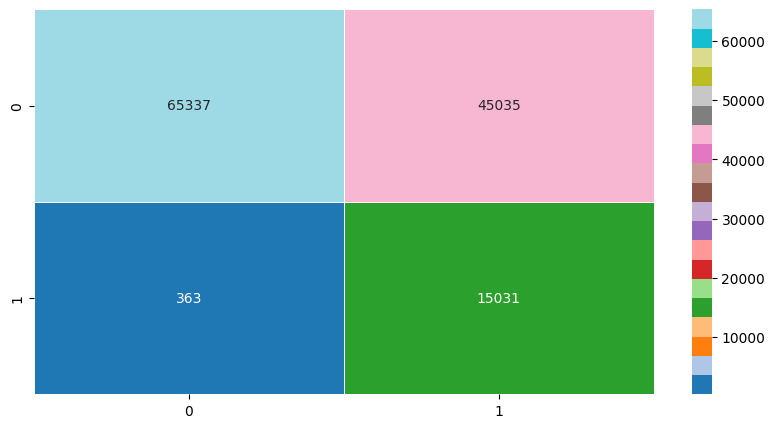

In [25]:
y_pred = logistic_model_os_rfe.predict(X_test_rfe)

cm = confusion_matrix(y_test, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))

print("AUC : ", round(roc_auc_score(y_test, logistic_model_os_rfe.predict(X_test_rfe)), 3))
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

Unfortunately, although this model performed decently better than the above model, this really won't suffice.

It may seem that linear models are not the way to go. We will explore other options.

We first try out a decision tree on the oversampled data

In [26]:
clf_tree = DecisionTreeClassifier().fit(os_data_X, os_data_y)

Accuracy :  0.965
Sensitivity :  0.86176
Specificity :  0.97885
Precision :  0.85
F1 Score:  0.856
AUC :  0.92
              precision    recall  f1-score   support

           0       0.98      0.98      0.98    110372
           1       0.85      0.86      0.86     15394

    accuracy                           0.96    125766
   macro avg       0.92      0.92      0.92    125766
weighted avg       0.96      0.96      0.96    125766



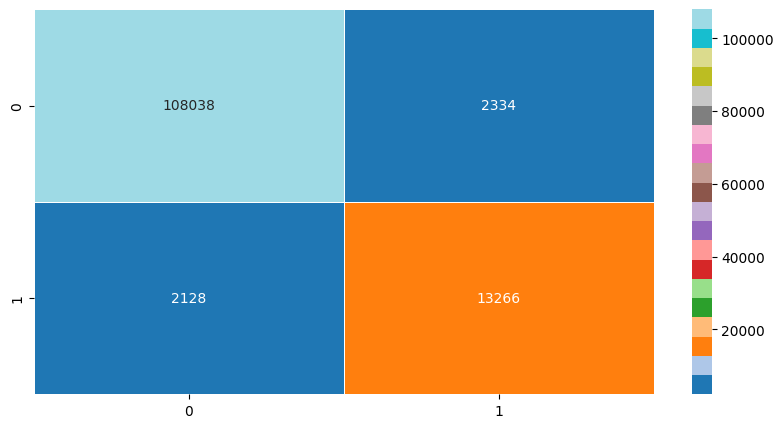

In [27]:
y_pred = clf_tree.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))
print("AUC : ", round(roc_auc_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

The decision tree classifier turned out very well, with an accuracy of 96.5% and AUC = 0.92.

In [28]:
rfc_os = RandomForestClassifier().fit(os_data_X , os_data_y)

Accuracy :  0.97
Sensitivity :  0.84702
Specificity :  0.98714
Precision :  0.902
F1 Score:  0.874
AUC :  0.91708
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    110372
           1       0.90      0.85      0.87     15394

    accuracy                           0.97    125766
   macro avg       0.94      0.92      0.93    125766
weighted avg       0.97      0.97      0.97    125766



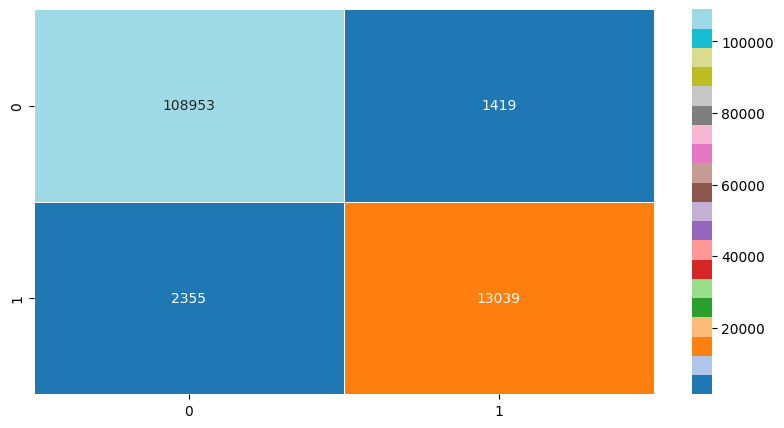

In [29]:
y_pred = rfc_os.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))
print ("AUC : ", round(roc_auc_score(y_test, y_pred),5))
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

## XGBoost

Here we will try using XGBoost to investigate if a better model will be attained.

We first attempy XGBoost on the original data

In [30]:
xg = xgb.XGBClassifier(n_estimators = 1000)
evaluation = [( X_train2, y_train2), ( X_test2, y_test2)]
xg.fit(X_train2, y_train2, eval_set=evaluation, eval_metric="auc", 
       early_stopping_rounds=20, verbose=100)

[0]	validation_0-auc:0.84402	validation_1-auc:0.84055


/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[56]	validation_0-auc:0.87143	validation_1-auc:0.85620


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy :  0.877
Sensitivity :  0.00494
Specificity :  0.99918
Precision :  0.455
F1 Score:  0.01
AUC :  0.50206
              precision    recall  f1-score   support

           0       0.88      1.00      0.93    110372
           1       0.46      0.00      0.01     15394

    accuracy                           0.88    125766
   macro avg       0.67      0.50      0.47    125766
weighted avg       0.83      0.88      0.82    125766



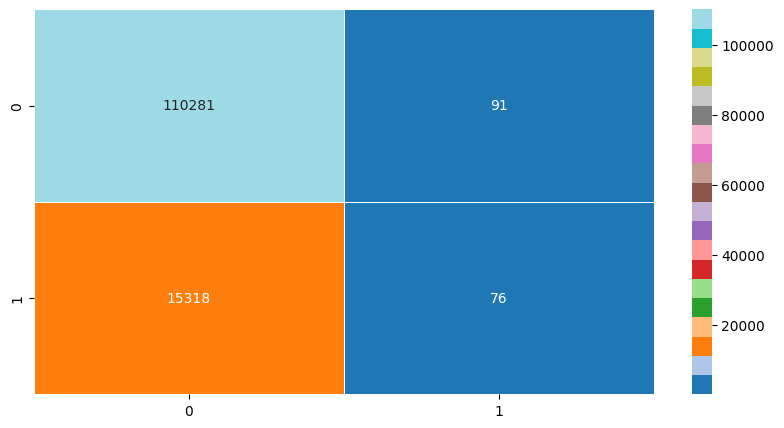

In [31]:
y_pred = xg.predict(X_test2)
cm = confusion_matrix(y_test2, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test2),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))
print ("AUC : ", round(roc_auc_score(y_test, y_pred),5))
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

The result is similar to the logistic regression with on the original data. The unbalanced nature of the data leads the model to predict majority response = 0. Which gives us a high accuracy but this isn't a valuable model.

We next try XGBoosting with the oversampled data.

In [32]:
evaluation = [( os_data_X2, os_data_y2), ( X_test2, y_test2)]
xg.fit(os_data_X2, os_data_y2, eval_set=evaluation, eval_metric="auc", 
       early_stopping_rounds=20, verbose=100)

/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


[0]	validation_0-auc:0.87294	validation_1-auc:0.82446
[35]	validation_0-auc:0.93186	validation_1-auc:0.83398


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=1000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Accuracy :  0.754
Sensitivity :  0.76549
Specificity :  0.75248
Precision :  0.301
F1 Score:  0.432
AUC :  0.759
              precision    recall  f1-score   support

           0       0.96      0.75      0.84    110372
           1       0.30      0.77      0.43     15394

    accuracy                           0.75    125766
   macro avg       0.63      0.76      0.64    125766
weighted avg       0.88      0.75      0.79    125766



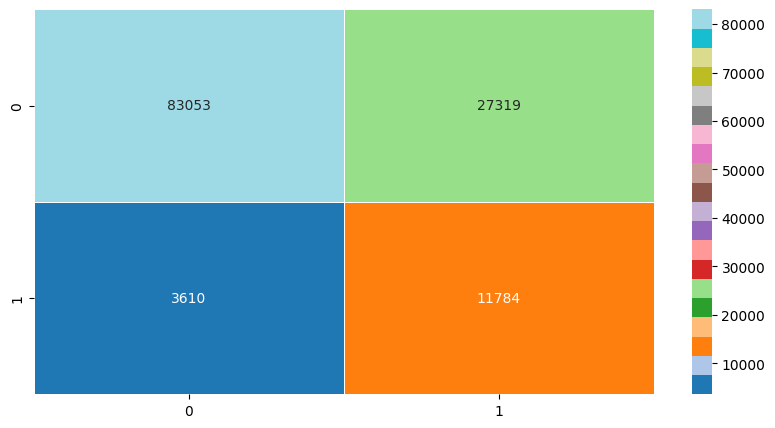

In [33]:
y_pred = xg.predict(X_test2)

cm = confusion_matrix(y_test2, y_pred)
Sensitivity = Recall = cm[1,1] / (cm[1,1] + cm[1,0])
Specificity = cm[0,0] / (cm[0,0] + cm[0,1])

print ("Accuracy : ", round(accuracy_score(y_pred, y_test),3))
print("Sensitivity : ", round(Sensitivity,5)) 
print("Specificity : ", round(Specificity,5))
print("Precision : ", round(precision_score(y_test, y_pred), 3))
print("F1 Score: ", round((2*precision_score(y_test, y_pred)*Recall)/(precision_score(y_test, y_pred) + Recall), 3))
print("AUC : ", round(roc_auc_score(y_test, y_pred), 3))
print(classification_report(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5,cmap='tab20')
plt.show()

Unfotunately, XGboosting didn't provide any better performing models

| Model | Features | Data | Accuracy | AUC |
|- | -| -| -|- |
|Logisitic Regression|all features|unbalanced data|0.876|0.504|
|Logisitic Regression|all features|SMOTE data|0.634|0.577|
|Logisitic Regression|top 4 features|SMOTE data|0.639|0.784|
|Decision Tree|all features|SMOTE data|0.965|0.920|
|Random Forest|all features|SMOTE data|0.970|0.917|
|XGBoost|all features|unbalanced data|0.877|0.502|
|XGBoost|all features|SMOTE data|0.754|0.759|


# Conclusion

The data set is strongly unbalanced, without dealing with the unbalanced data we tend to get models that predict almost all response to be uninterested in vehicle insurance. To deal with this we used SMOTE, which resamples the minority portion of the data randomly in order to balanced it with the majority portion. We got significantly better results by doing so. We found the best models to be the decision tree and random forest approaches. They have accuracies of around 97% and both have high AUC values. The decision tree is less computationally expensive and performs just as good as the random forest model.